In [1]:
!pip install --upgrade --ignore-installed kaggle

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 153kB 8.3MB/s 
     |████████████████████████████████| 235kB 16.3MB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 143kB 15.9MB/s 
     |████████████████████████████████| 184kB 17.1MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=2425246392b9f8b7f3f1b3367c31b3ba195e3b07fe9d7375a9be3f36b2622c68
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=703f20886977bedfa2dbf86be8b952c4f63ebd7a21fcc9ce6445dd33af9873ad
  Stored in directory: /root/.cache/pip/wheels/67/b8/ba/041548f30a6fc058c9b3f79

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aliarshad01","key":"19a9404099fe7b8b4539d3c915da0e2e"}'}

In [4]:
!mkdir ~/.kaggle #created at root folder in colab

In [5]:
#copy
!cp kaggle.json ~/.kaggle

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
utkarshxy/who-worldhealth-statistics-2020-complete             World Health 2020 🌏 | For Geospatial Analysis         1MB  2021-01-06 16:22:50           1004        137  1.0              
gpreda/pfizer-vaccine-tweets                                   Pfizer Vaccine Tweets                               416KB  2021-01-07 12:08:56            744         75  1.0              
google/android-smartphones-high-accuracy-datasets              Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            143         31  0.875            
ashkhagan/women-representation-in-city-property-sanfrancisco   Wo

In [8]:
#downlading dataset from kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

 94% 326M/346M [00:02<00:00, 155MB/s]
100% 346M/346M [00:02<00:00, 148MB/s]


In [9]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

In [10]:
!rm -r /content/seg_pred

In [11]:
!unzip -q /content/drive/MyDrive/Test_data.zip

In [12]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [13]:
train_dir = os.path.dirname('/content/seg_train/seg_train/')
test_dir = os.path.dirname('/content/seg_test/seg_test/')
pred_dir = os.path.dirname('/content/seg_pred/seg_pred/')

In [14]:
## Generators ##
 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
)

pred_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [15]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    batch_size = 128,
    shuffle=True,
    target_size = (150, 150)
)

test_dataset = valid_datagen.flow_from_directory(
    test_dir,
    class_mode='categorical',
    batch_size = 128,
    shuffle=False,
    target_size = (150, 150)
)

pred_dataset = pred_datagen.flow_from_directory(
    pred_dir,
    class_mode='categorical',
    batch_size = 128,
    shuffle=False,
    target_size = (150, 150)
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [16]:
# load VGG16 model without classification layers
model = VGG16(include_top=False,weights='imagenet', input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [18]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [19]:
from keras.optimizers import SGD, Adam
import numpy
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [20]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.00001)

cb_checkpointer = ModelCheckpoint(filepath = 'vgg16_checkpoint.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

In [ ]:
vgg16_clf = model.fit(train_dataset, validation_data = test_dataset, epochs = 10, callbacks=[cb_checkpointer, learning_rate_reduction])

Epoch 1/10
110/110 [==============================] - 101s 832ms/step - loss: 1.0377 - accuracy: 0.5905 - val_loss: 0.3264 - val_accuracy: 0.8857
Epoch 2/10
110/110 [==============================] - 89s 809ms/step - loss: 0.3876 - accuracy: 0.8566 - val_loss: 0.2819 - val_accuracy: 0.9013
Epoch 3/10
110/110 [==============================] - 89s 803ms/step - loss: 0.2917 - accuracy: 0.8931 - val_loss: 0.2656 - val_accuracy: 0.8987

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/10
110/110 [==============================] - 89s 803ms/step - loss: 0.2545 - accuracy: 0.9110 - val_loss: 0.2246 - val_accuracy: 0.9200
Epoch 5/10
110/110 [==============================] - 88s 798ms/step - loss: 0.2273 - accuracy: 0.9213 - val_loss: 0.2319 - val_accuracy: 0.9157

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 6/10
110/110 [==============================] - 88s 797ms/step - loss: 0.2045 - accuracy: 0.9292 - val_loss

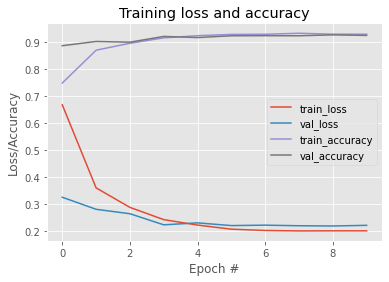

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, vgg16_clf.history['loss'], label='train_loss')
plt.plot(N, vgg16_clf.history['val_loss'], label='val_loss')
plt.plot(N, vgg16_clf.history['accuracy'], label='train_accuracy')
plt.plot(N, vgg16_clf.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [22]:
score = model.evaluate(pred_dataset, batch_size=128)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

58/58 [==============================] - 15s 133ms/step - loss: 0.2125 - accuracy: 0.9265
Test Loss =  0.2811321020126343
Test Accuracy =  0.9100123047828674


In [22]:
##CONFUSION MATRIX
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(pred_dataset)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cnf_matrix = confusion_matrix(pred_dataset.classes, y_pred)
print(cnf_matrix)
print('Classification Report')
target_names = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']
print(classification_report(pred_dataset.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1082    3    0    2    6   51]
 [   4 1154    1    2    2    3]
 [   1    9 1113  160   43    4]
 [   2    8   91 1132   62    2]
 [  10    4   24   49 1026   15]
 [  77    9    4    1    8 1137]]
Classification Report
              precision    recall  f1-score   support

   Buildings       0.92      0.95      0.93      1144
      Forest       0.97      0.99      0.98      1166
     Glacier       0.90      0.84      0.87      1330
    Mountain       0.84      0.87      0.86      1297
         Sea       0.89      0.91      0.90      1128
      Street       0.94      0.92      0.93      1236

    accuracy                           0.91      7301
   macro avg       0.91      0.91      0.91      7301
weighted avg       0.91      0.91      0.91      7301



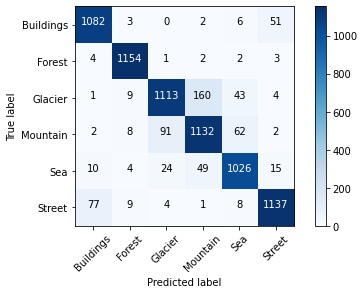

In [26]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cnf_matrix,classes=target_names)

In [111]:
## prediction on some test images
from PIL import Image
test_img_paths = ["/content/seg_pred/seg_pred/forest/10209.jpg",
                  "/content/seg_pred/seg_pred/buildings/10048.jpg",
                  "/content/seg_pred/seg_pred/glacier/10276.jpg"]
img_list = [Image.open(img_path) for img_path in test_img_paths]
classes =['buildings', 'forest','glacier', 'mountain', 'sea', 'street']

test_batch = np.stack([preprocess_input(np.array(img.resize((150,150))))
                             for img in img_list])

In [112]:
pred_probs = model.predict(test_batch)
pred_probs

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

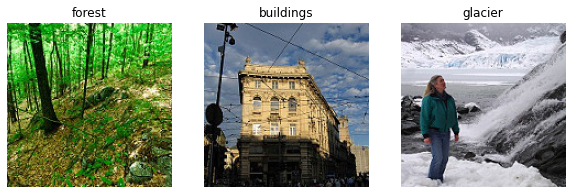

In [113]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(img_list), figsize=(10, 6))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(classes[np.argmax(pred_probs[i])])
    ax.imshow(img)

In [21]:
##Load Weights
model.load_weights('/content/drive/MyDrive/vgg_transfer_trained_wts.h5')

In [ ]:
##Save Weights
model.save_weights('/content/drive/MyDrive/vgg_transfer_trained_wts.h5')